### Resumen previo: 
Aca resuelvo el problema unidimensional, pero original. Solo que uso una grilla 1D y mucho mas pequeña para ver comportamientos nomas. La fuente tiene $a_0=1$
## Parte tres: Problema original
Ahora teniendo estas dos primeras partes comprendidas, vamos a procurar resolver el problema original en una dimensión.
En este caso la fuente está dada por
\begin{equation} 
a(x) =
\left\{
	\begin{array}{ll}
		a_0 q(s)  & \mbox{if } 0 < s \leq 1 \\
		0 & \mbox{if } s \geq 1
	\end{array}
\right.
\end{equation}
donde \begin{equation} 
s= \sqrt{ (\frac{\rho}{R})^2 }
\end{equation}
\begin{equation}
q(s)=1 - s^4 (1-5(s-1)+15(s-1)^2 -35(s-1)^3+70(s-1)^4 )
\end{equation}

In [1]:
Atom = false
#Atom = true

false

In [2]:
using Gridap
using GridapODEs
if  Atom == false
    using GridapMakie, GLMakie
end
using FileIO
using GridapGmsh
using gmsh

In [3]:
L = 80.
model = GmshDiscreteModel("modelos/1D80.msh")

Info    : Reading 'modelos/1D80.msh'...
Info    : 3 entities
Info    : 3201 nodes
Info    : 3202 elements
Info    : Done reading 'modelos/1D80.msh'


UnstructuredDiscreteModel()

In [4]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

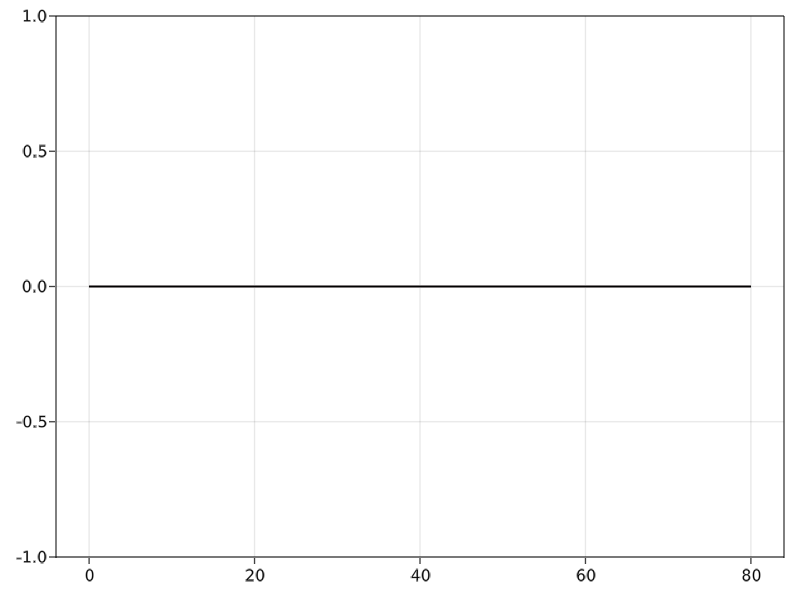

In [5]:
if Atom == false 
    fig, ax = plot(Ω)
    wireframe!(Ω, color=:black, linewidth=2)
    fig
end

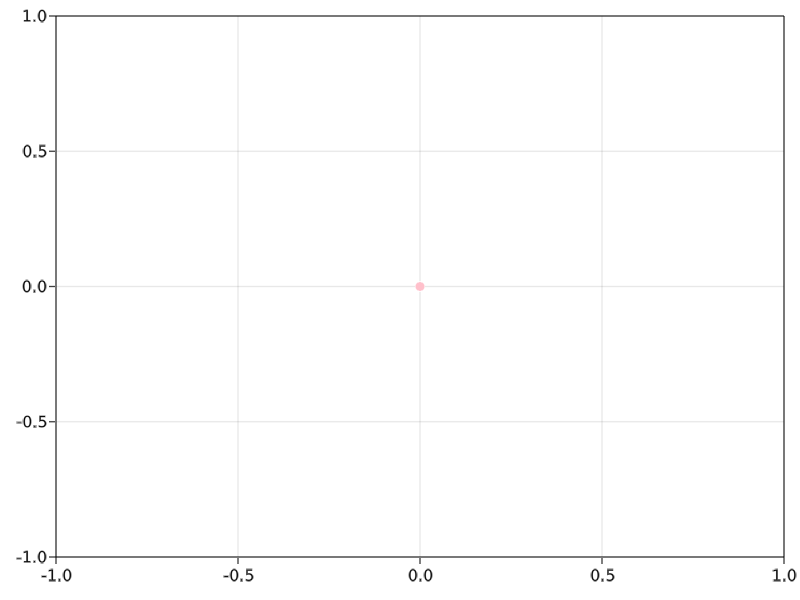

In [6]:
neumanntags_L= ["L"]
Γ_L = BoundaryTriangulation(model,tags=neumanntags_L)
dΓ_L = Measure(Γ_L,degree)
if Atom == false 
    fig = plot(Γ_L, linewidth=8
    #, shading=true
    )
end

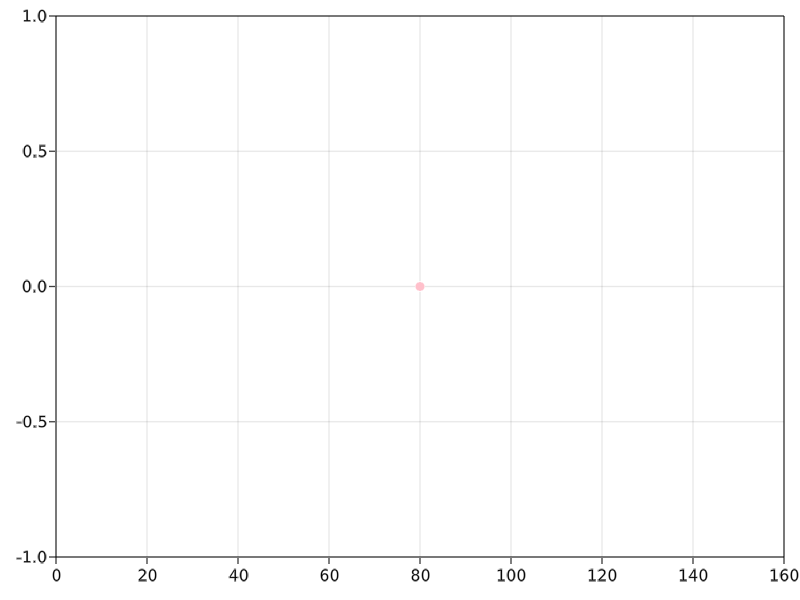

In [7]:
neumanntags_R= ["R"]
Γ_R = BoundaryTriangulation(model,tags=neumanntags_R)
dΓ_R = Measure(Γ_R,degree)
if Atom == false 
    fig = plot(Γ_R, linewidth=8
    #, shading=true
    )
end

In [8]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,conformity=:H1)
U = TrialFESpace(V)

UnconstrainedFESpace()

In [9]:
a0=1.
R=20

s(x) = sqrt((x[1]/ R)^2 ) 
q(x)=1. - s(x) ^4 * (1. - 5. *(s(x) -1.) + 15. * (s(x)-1.)^2 - 35. *(s(x) -1.)^3 +70. * (s(x)- 1.)^4)

function α(x)
    if s(x)  < 1.0
        return q(x)*a0
        end
    if s(x) >= 1.0
       return  0.
    end
end
t(x) = 8*π*α(x)

#Cond de Newman borde centro
c(x)=0.



c (generic function with 1 method)

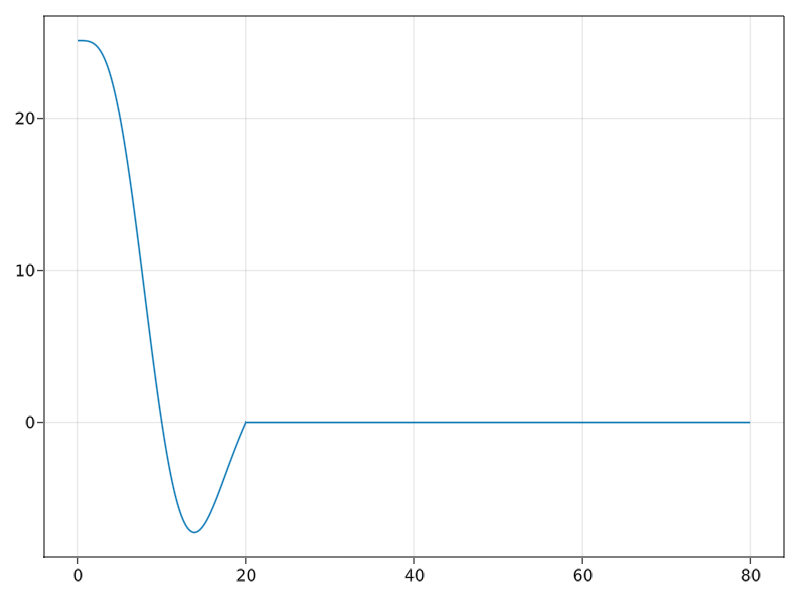

In [10]:
x = range(0., L, length=1000)
lines(x,t, label= "exact") 

In [11]:
ρ(x)=x[1]
d(x) = VectorValue(2. )
invrho3(x)=3. / x[1]
ρvec(x) = VectorValue(1.)

ρvec (generic function with 1 method)

In [12]:
a(u,v) = ∫( - ∇(v) ⋅ ∇(u)*ρ +(d ⋅ ∇(u))*v) *dΩ -∫( v *( u  ) )*dΓ_R 
b(v) = ∫(-v * t* ρ) *dΩ - ∫( v *c*ρ ) *dΓ_L

b (generic function with 1 method)

In [13]:
op = AffineFEOperator(a,b,U,V)

AffineFEOperator()

In [14]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [15]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

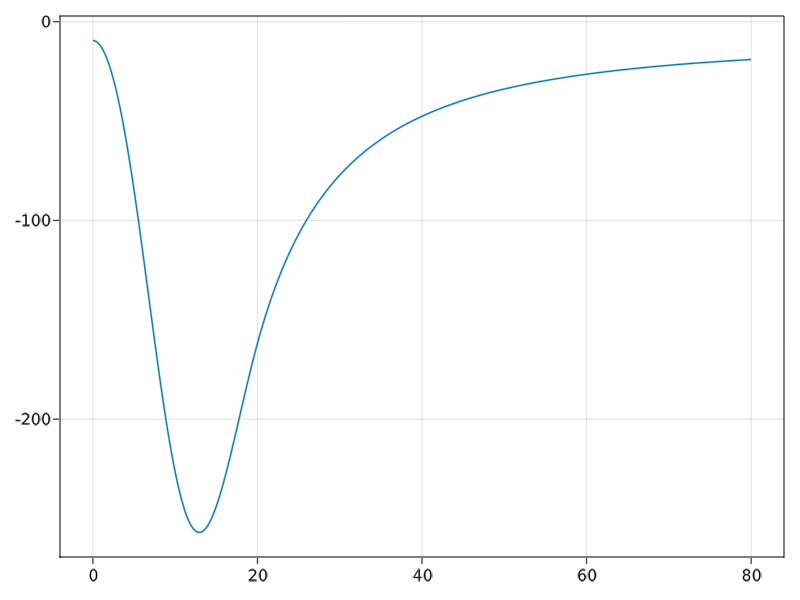

In [16]:
x = range(0., L, length=1000)
lines(x, evaluate(uh, Gridap.Point.(x)), label= "u")

In [17]:
f1=∇(uh) ⋅ ρvec

OperationCellField():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

In [18]:
invrho3(x)=3. /x[1]

invrho3 (generic function with 1 method)

In [19]:
eq_cuad_f=(Δ(uh)+invrho3*f1+t)*(Δ(uh)+invrho3*f1+t)

OperationCellField():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

In [20]:
L2norm_eq_quad_f= sqrt(sum( ∫(eq_cuad_f)*dΩ ))

0.04295621535590287

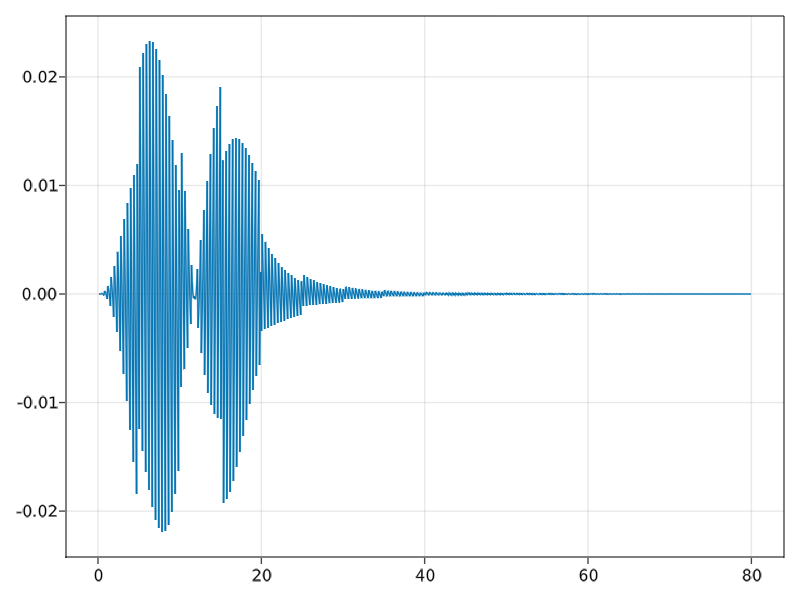

In [21]:
x = range(0., L, length=1000) #residual
lines(x, evaluate(Δ(uh)+invrho3*f1+t, Gridap.Point.(x)), label= "u")

In [22]:
function t1(x)
  return 2. * π*α(x)
end

function t2(x)
  return 6. * π*α(x)
end

t2 (generic function with 1 method)

In [23]:
F=f1*f1

OperationCellField():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

In [24]:
res(w,q)=  ∫(  - (∇(q) ⋅ ∇(w))*ρ  + t1*( (q*ρ * ρ)/(w*w*w)) +  (0.25 * F *ρ *  ρ* ρ) * q*(1/(w*w*w*w*w*w*w)) ) *dΩ +∫( c * q *ρ ) *dΓ_L +∫( -q * (w- 1.)  ) *dΓ_R 

res (generic function with 1 method)

In [25]:
jac(w,dw,q)= ∫(  - ( ∇(q) ⋅ ∇(dw))*ρ   - ((dw* q*ρ * ρ)/(w*w*w*w))*t2 -(1.75 * F *ρ  * ρ* ρ) * dw *q*(1/(w*w*w*w*w*w*w*w)) ) *dΩ+∫( -q * (dw)  ) *dΓ_R

jac (generic function with 1 method)

In [26]:
oppsi = FEOperator(res,jac,U,V)

FEOperatorFromWeakForm()

In [27]:
using LineSearches: BackTracking
nls = NLSolver(
  show_trace=true, method=:trust_region, linesearch=BackTracking(),ftol=1E-20, xtol= 1E-20,iterations=100)
solver = FESolver(nls)

NonlinearFESolver()

In [28]:
seed(x)=1. 
w0=interpolate_everywhere(seed,U)

SingleFieldFEFunction():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

In [29]:
w, = solve!(w0,solver,oppsi)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.336528e+03              NaN
     1     3.273558e+03     1.155623e+01
     2     1.285404e+03     1.319481e+01
     3     5.046997e+02     1.508310e+01
     4     1.981446e+02     1.724047e+01
     5     7.777777e+01     1.970919e+01
     6     3.052104e+01     2.253223e+01
     7     1.197076e+01     2.575318e+01
     8     4.691220e+00     2.940629e+01
     9     1.835855e+00     3.348813e+01
    10     7.164723e-01     3.788697e+01
    11     2.769515e-01     4.221651e+01
    12     1.022410e-01     4.514155e+01
    13     3.294259e-02     4.379772e+01
    14     1.566828e-02     3.869969e+01
    15     8.785290e-03     2.796242e+01
    16     3.050139e-03     1.616607e+01
    17     4.031423e-04     7.098767e+00
    18     8.217371e-06     1.139197e+00
    19     3.809790e-09     2.518786e-02
    20     2.232969e-11     1.203435e-05
    21     3.333422e-11     0.000000e+00
    22     3.33342

(SingleFieldFEFunction(), NLSolversCache())

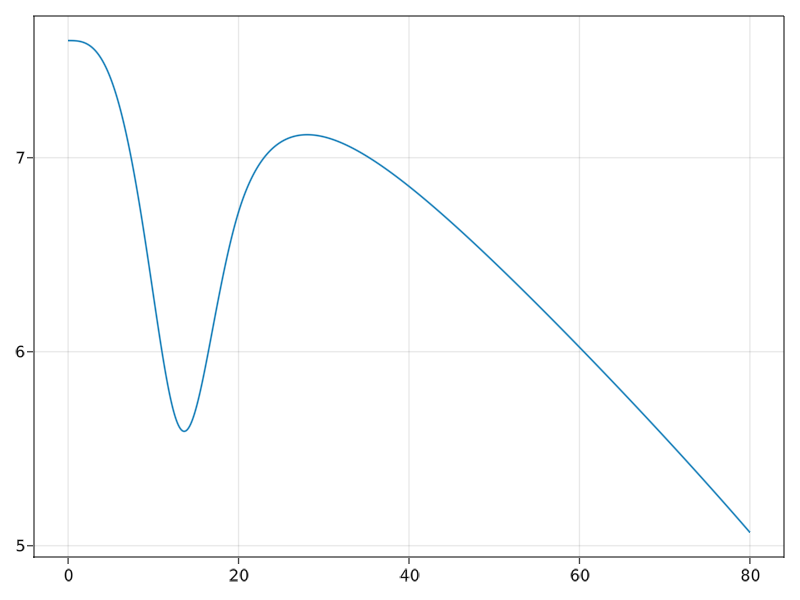

In [30]:
x = range(0., L, length=1000)
lines(x, evaluate(w,Gridap.Point.(x)), label= "u")

In [31]:
invrho(x)=1. /x[1]
partialψ=ρvec ⋅ ∇(w)

OperationCellField():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

In [32]:
eq_cuad= (Δ(w)+invrho*partialψ + t1 *(ρ/ (w*w*w))+F *ρ*ρ/(w*w*w*w*w*w*w) ) * (Δ(w)+invrho*partialψ + t1 *(ρ/ (w*w*w))+F *ρ*ρ/(w*w*w*w*w*w*w))

OperationCellField():
 num_cells: 3200
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13647530485802284227

In [33]:
L2norm_eq_quad= sqrt(sum( ∫(eq_cuad )*dΩ ))

0.4502291547554497

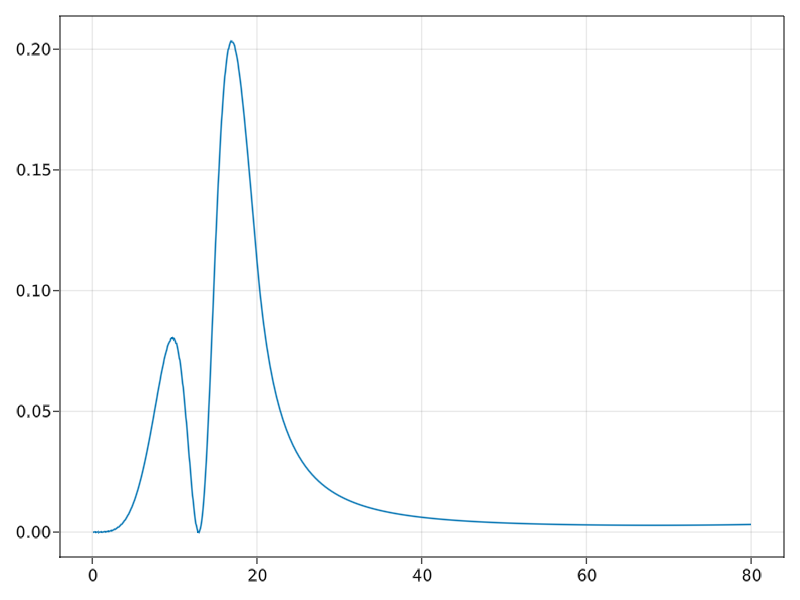

In [34]:
x = range(0., L, length=1000)
lines(x, evaluate(Δ(w)+invrho*partialψ + t1 *(ρ/ (w*w*w))+F *ρ*ρ/(w*w*w*w*w*w*w),Gridap.Point.(x)), label= "u")